# Multi-Label U-Net Training (With Electronic Glitches) on Real ACT Data

## 1. Imports and Configuration

In [1]:
import os
from pathlib import Path
import random
import time
import datetime
import csv
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from PIL import Image
import csv
from torchmetrics.classification import MultilabelJaccardIndex, MultilabelAccuracy



### 1.1. Configuration

In [ ]:
NUM_CLASSES    = 3                   # CR, PS, EL
BATCH_SIZE     = 8
EPOCHS         = 10 * 12 
LR             = 1e-3
DEVICE         = "cuda" if torch.cuda.is_available() else "cpu"
CPU_COUNT      = os.cpu_count()
NUM_WORKERS    = 32

CHECKPOINT_DIR = Path("checkpoints_multilabel_withEL")
CHECKPOINT_DIR.mkdir(exist_ok=True)
LOG_PATH       = Path("checkpoints_multilabel_withEL.csv")

print(f"Device: {DEVICE}, CUDA Available: {torch.cuda.is_available()}")

Device: cuda, CUDA Available: True


## 2. Sanity Check: Load & Display One Raw Image

Raw image range: min=0.0, max=181.0


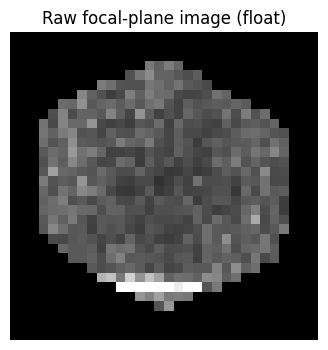

In [3]:
example_img_path = Path("/home/theanas12/anasProjects/cmb_Unet_run1/data/real_converted_images32/images/point_source/TOD_1567419530.1567428401.ar5:f090_converted_10914-11427.png")

# Load and display
import PIL.Image as Image
img = np.array(Image.open(example_img_path).convert('F'), dtype=np.float32)
print(f"Raw image range: min={img.min()}, max={img.max()}")
plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray')
plt.title('Raw focal-plane image (float)')
plt.axis('off')
plt.show()

## 3. Optional Normalization Transform

Normalized image range: min=0.000, max=1.000


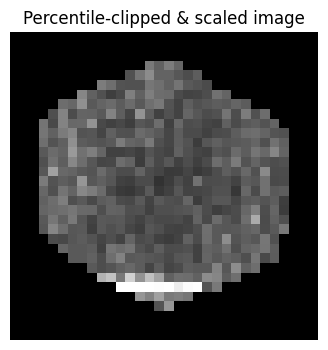

In [4]:
# Re-apply the same normalization as synthetic pipeline if needed.
# Here: percentile clipping to [0.5,99.5] then scale to [0,1].
# %%
def pct_clip_norm(img, lo_pct=0.5, hi_pct=99.5):
    lo, hi = np.percentile(img, [lo_pct, hi_pct])
    img2 = np.clip(img, lo, hi)
    return (img2 - lo) / (hi - lo + 1e-12)

# Sanity check of normalization
normed = pct_clip_norm(img)
print(f"Normalized image range: min={normed.min():.3f}, max={normed.max():.3f}")
plt.figure(figsize=(4,4))
plt.imshow(normed, cmap='gray')
plt.title('Percentile-clipped & scaled image')
plt.axis('off')
plt.show()

## 4. Dataset Definition

In [5]:
# Cell 3: Dataset Definition

class TelescopeDataset(Dataset):
    def __init__(self, img_dir, mask_dir_base, transform=None):
        self.transform     = transform
        self.samples       = []
        for cls in ['cosmic_ray','point_source','electronic_glitch']:
            for p in (img_dir/cls).glob("*.png"):
                self.samples.append((p, cls))
        self.mask_dir_base = mask_dir_base

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, cls = self.samples[idx]
        img = np.array(Image.open(img_path).convert('F'), dtype=np.float32)
        if self.transform: img = self.transform(img)
        img_t = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # (1,H,W)

        masks = []
        for mcls in ['cosmic_ray','point_source','electronic_glitch']:
            mpath = self.mask_dir_base / mcls / img_path.name
            if mpath.exists():
                m = (np.array(Image.open(mpath).convert('L'),dtype=np.uint8)>0).astype(np.uint8)
            else:
                m = np.zeros_like(img, dtype=np.uint8)
            masks.append(m)
        m_t = torch.tensor(np.stack(masks,0), dtype=torch.float32)   # (3,H,W)
        return img_t, m_t


## 5. Prepare DataLoaders

In [6]:
# Cell 4: Data Splits & Loaders + Sanity Check

base = Path("/home/theanas12/anasProjects/cmb_Unet_run1/data/real_converted_images32")
ds   = TelescopeDataset(base/'images', base/'masks', transform=pct_clip_norm)

tot      = len(ds)
train_e  = int(tot*0.7); val_e = int(tot*0.85)
ids      = list(range(tot)); random.shuffle(ids)
train_i, val_i, test_i = ids[:train_e], ids[train_e:val_e], ids[val_e:]

train_loader = DataLoader(ds, batch_size=BATCH_SIZE, sampler=None, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(ds, batch_size=BATCH_SIZE, sampler=None, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(ds, batch_size=BATCH_SIZE, sampler=None, shuffle=False, num_workers=NUM_WORKERS)

print(f"Sizes → train:{train_e}, val:{val_e-train_e}, test:{tot-val_e}")
imgs, msks = next(iter(train_loader))
print("Batch shapes:", imgs.shape, msks.shape)  # (B,1,H,W), (B,3,H,W)


Sizes → train:2790, val:598, test:599


Batch shapes: torch.Size([8, 1, 32, 32]) torch.Size([8, 3, 32, 32])


## 6. Model, Losses, Metrics, Optimizer

In [7]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_c, out_c):
        super().__init__(nn.Conv2d(in_c,out_c,3,padding=1,bias=False),
                         nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))

class TinyUNet(nn.Module):
    def __init__(self, n_classes=NUM_CLASSES, base_c=32, p_drop=0.25):
        super().__init__()
        self.enc1 = nn.Sequential(ConvBNReLU(1,base_c), ConvBNReLU(base_c,base_c))
        self.enc2 = nn.Sequential(nn.MaxPool2d(2), ConvBNReLU(base_c,base_c*2))
        self.bott = nn.Sequential(nn.MaxPool2d(2), ConvBNReLU(base_c*2,base_c*4))
        self.up1  = nn.ConvTranspose2d(base_c*4,base_c*2,2,stride=2)
        self.dec1 = nn.Sequential(ConvBNReLU(base_c*4,base_c*2), nn.Dropout2d(p_drop))
        self.up2  = nn.ConvTranspose2d(base_c*2,base_c,2,stride=2)
        self.dec2 = nn.Sequential(ConvBNReLU(base_c*2,base_c),   nn.Dropout2d(p_drop))
        self.outc = nn.Conv2d(base_c, n_classes, 1)

    def forward(self,x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        b  = self.bott(e2)
        d1 = self.up1(b); d1 = self.dec1(torch.cat([d1,e2],1))
        d2 = self.up2(d1); d2 = self.dec2(torch.cat([d2,e1],1))
        return self.outc(d2)  # logits




class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__(); self.eps = eps
    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        num = 2 * (preds * targets).sum(dim=(2,3))
        den = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + self.eps
        dice = 1 - (num / den)
        return dice.mean()
    

model = TinyUNet(n_classes=NUM_CLASSES).to(DEVICE)


bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

# Metrics
metric_iou = MultilabelJaccardIndex(num_labels=NUM_CLASSES, threshold=0.5, average=None).to(DEVICE)
metric_acc = MultilabelAccuracy(num_labels=NUM_CLASSES, threshold=0.5, average=None).to(DEVICE)

# Optimizer & scheduler
opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=3, factor=0.3)


## 7. Training & Validation Loops

### 7.1.Epoch Function

In [8]:
def run_epoch(loader, train=True, epoch_idx=0):
    model.train(train)
    total_loss, batches = 0.0, 0
    metric_iou.reset(); metric_acc.reset()

    loop = tqdm(loader, desc=("train" if train else "val")+f" {epoch_idx:03d}", leave=False)
    for i,(imgs,msks) in enumerate(loop):
        imgs, msks = imgs.to(DEVICE), msks.to(DEVICE)
        if i==0 and epoch_idx==1:
            print(f"[Sanity] imgs={imgs.shape}, msks={msks.shape}")
        logits = model(imgs)
        if i==0 and epoch_idx==1:
            print(f"[Sanity] logits={logits.shape}, msks={msks.shape}")

        loss = 0.5*bce_loss(logits,msks) + 0.5*dice_loss(logits,msks)
        if train:
            opt.zero_grad(); loss.backward(); opt.step()

        total_loss += loss.item(); batches+=1
        metric_iou.update(torch.sigmoid(logits), msks.int())
        metric_acc.update(torch.sigmoid(logits), msks.int())
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss/batches
    iou      = metric_iou.compute(); acc = metric_acc.compute()
    return avg_loss, iou.mean().item(), acc.mean().item(), iou, acc

### 7.2. Saving Checkpoints and Logging Logic

In [ ]:
def save_ckpt(model, optimizer, epoch, tag):
    fname = CHECKPOINT_DIR / f"unet_multilabel_withEL_ep{epoch}_{tag}.pt"
    torch.save({"epoch":epoch, "model":model.state_dict(), "optimizer":optimizer.state_dict()}, fname)
    print(f"✅ saved → {fname}")

def next_run_id():
    if LOG_PATH.exists(): return sum(1 for _ in open(LOG_PATH))
    return 1

def log_run(**fields):
    header = not LOG_PATH.exists()
    with open(LOG_PATH,'a',newline='') as f:
        writer = csv.DictWriter(f, fieldnames=fields.keys())
        if header: writer.writeheader()
        writer.writerow(fields)

### 7.3. Training Loop

In [10]:
# Training loop

start_time = time.time()
train_hist, val_hist = [], []
iou_tr_hist, iou_val_hist = [], []
acc_tr_hist, acc_val_hist = [], []
best_iou=0; best_val_loss=1e9; stall=0

for ep in trange(1, EPOCHS+1, desc='Epochs'):
    tr_loss, tr_iou, tr_acc, _, _ = run_epoch(train_loader, True,  ep)
    val_loss, val_iou, val_acc, val_vec, _ = run_epoch(val_loader, False, ep)
    sched.step(val_loss)

    print(f"Epoch{ep:03d}|train={tr_loss:.3f} val={val_loss:.3f}|" +
          f"CR={val_vec[0]:.3f} PS={val_vec[1]:.3f} EL={val_vec[2]:.3f}")

    train_hist.append(float(tr_loss));  val_hist.append(float(val_loss))
    iou_tr_hist.append(float(tr_iou)); iou_val_hist.append(val_vec.cpu().numpy())
    acc_tr_hist.append(float(tr_acc));  acc_val_hist.append(float(val_acc))

    # checkpoints
    save_ckpt(model,opt,ep,'last')
    if val_iou>best_iou:
        best_iou=val_iou; save_ckpt(model,opt,ep,'best')
    if val_loss < best_val_loss-1e-5:
        best_val_loss=val_loss; stall=0
    else:
        stall+=1; print(f" no_imp {stall}/8")
        if stall>=8: print("Early stop"); break

elapsed=time.time()-start_time
print(f"Done — best IoU={best_iou:.3f} in {int(elapsed)}s")
print(f"Final IoU CR={val_vec[0]:.3f}, PS={val_vec[1]:.3f}, EL={val_vec[2]:.3f}")

Epochs:   0%|          | 0/120 [00:00<?, ?it/s]

[Sanity] imgs=torch.Size([8, 1, 32, 32]), msks=torch.Size([8, 3, 32, 32])
[Sanity] logits=torch.Size([8, 3, 32, 32]), msks=torch.Size([8, 3, 32, 32])


[Sanity] imgs=torch.Size([8, 1, 32, 32]), msks=torch.Size([8, 3, 32, 32])
[Sanity] logits=torch.Size([8, 3, 32, 32]), msks=torch.Size([8, 3, 32, 32])


Epochs:   1%|          | 1/120 [00:11<23:46, 11.99s/it]

Epoch001|train=0.511 val=0.435|CR=0.462 PS=0.648 EL=0.187
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep1_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep1_best.pt


Epochs:   2%|▏         | 2/120 [00:23<22:41, 11.54s/it]

Epoch002|train=0.433 val=0.421|CR=0.572 PS=0.727 EL=0.170
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep2_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep2_best.pt


Epochs:   2%|▎         | 3/120 [00:34<21:55, 11.25s/it]

Epoch003|train=0.427 val=0.420|CR=0.558 PS=0.767 EL=0.200
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep3_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep3_best.pt


Epochs:   3%|▎         | 4/120 [00:45<21:38, 11.20s/it]

Epoch004|train=0.424 val=0.418|CR=0.565 PS=0.770 EL=0.204
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep4_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep4_best.pt


Epochs:   4%|▍         | 5/120 [00:56<21:35, 11.27s/it]

Epoch005|train=0.422 val=0.420|CR=0.500 PS=0.766 EL=0.211
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep5_last.pt
 no_imp 1/8


Epochs:   5%|▌         | 6/120 [01:08<21:47, 11.47s/it]

Epoch006|train=0.422 val=0.415|CR=0.579 PS=0.786 EL=0.205
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep6_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep6_best.pt


Epochs:   6%|▌         | 7/120 [01:19<21:23, 11.36s/it]

Epoch007|train=0.420 val=0.415|CR=0.578 PS=0.762 EL=0.201
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep7_last.pt


Epochs:   7%|▋         | 8/120 [01:31<21:17, 11.40s/it]

Epoch008|train=0.419 val=0.415|CR=0.590 PS=0.807 EL=0.196
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep8_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep8_best.pt
 no_imp 1/8


Epochs:   8%|▊         | 9/120 [01:42<20:49, 11.25s/it]

Epoch009|train=0.419 val=0.415|CR=0.580 PS=0.784 EL=0.191
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep9_last.pt
 no_imp 2/8


Epochs:   8%|▊         | 10/120 [01:53<20:37, 11.25s/it]

Epoch010|train=0.418 val=0.412|CR=0.606 PS=0.823 EL=0.222
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep10_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep10_best.pt


Epochs:   9%|▉         | 11/120 [02:04<20:19, 11.19s/it]

Epoch011|train=0.417 val=0.413|CR=0.590 PS=0.826 EL=0.223
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep11_last.pt
 no_imp 1/8


Epochs:  10%|█         | 12/120 [02:15<20:10, 11.21s/it]

Epoch012|train=0.416 val=0.411|CR=0.618 PS=0.812 EL=0.229
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep12_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep12_best.pt


Epochs:  11%|█         | 13/120 [02:26<19:58, 11.20s/it]

Epoch013|train=0.416 val=0.412|CR=0.610 PS=0.716 EL=0.223
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep13_last.pt
 no_imp 1/8


Epochs:  12%|█▏        | 14/120 [02:37<19:39, 11.12s/it]

Epoch014|train=0.416 val=0.412|CR=0.603 PS=0.819 EL=0.215
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep14_last.pt
 no_imp 2/8


Epochs:  12%|█▎        | 15/120 [02:48<19:31, 11.16s/it]

Epoch015|train=0.415 val=0.411|CR=0.609 PS=0.837 EL=0.220
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep15_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep15_best.pt
 no_imp 3/8


Epochs:  13%|█▎        | 16/120 [02:59<19:07, 11.03s/it]

Epoch016|train=0.415 val=0.409|CR=0.619 PS=0.826 EL=0.225
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep16_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep16_best.pt


Epochs:  14%|█▍        | 17/120 [03:10<19:01, 11.08s/it]

Epoch017|train=0.414 val=0.410|CR=0.608 PS=0.787 EL=0.220
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep17_last.pt
 no_imp 1/8


Epochs:  15%|█▌        | 18/120 [03:22<19:02, 11.20s/it]

Epoch018|train=0.414 val=0.408|CR=0.625 PS=0.822 EL=0.223
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep18_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep18_best.pt


Epochs:  16%|█▌        | 19/120 [03:34<19:07, 11.36s/it]

Epoch019|train=0.414 val=0.412|CR=0.595 PS=0.829 EL=0.255
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep19_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep19_best.pt
 no_imp 1/8


Epochs:  17%|█▋        | 20/120 [03:45<18:43, 11.24s/it]

Epoch020|train=0.413 val=0.409|CR=0.618 PS=0.828 EL=0.246
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep20_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep20_best.pt
 no_imp 2/8


Epochs:  18%|█▊        | 21/120 [03:56<18:29, 11.21s/it]

Epoch021|train=0.413 val=0.412|CR=0.616 PS=0.825 EL=0.248
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep21_last.pt
 no_imp 3/8


Epochs:  18%|█▊        | 22/120 [04:07<18:17, 11.20s/it]

Epoch022|train=0.413 val=0.407|CR=0.628 PS=0.845 EL=0.249
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep22_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep22_best.pt


Epochs:  19%|█▉        | 23/120 [04:18<18:13, 11.28s/it]

Epoch023|train=0.412 val=0.408|CR=0.627 PS=0.833 EL=0.240
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep23_last.pt
 no_imp 1/8


Epochs:  20%|██        | 24/120 [04:30<18:19, 11.45s/it]

Epoch024|train=0.412 val=0.415|CR=0.573 PS=0.834 EL=0.233
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep24_last.pt
 no_imp 2/8


Epochs:  21%|██        | 25/120 [04:41<17:47, 11.23s/it]

Epoch025|train=0.411 val=0.407|CR=0.599 PS=0.825 EL=0.284
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep25_last.pt


Epochs:  22%|██▏       | 26/120 [04:52<17:27, 11.15s/it]

Epoch026|train=0.411 val=0.408|CR=0.634 PS=0.845 EL=0.214
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep26_last.pt
 no_imp 1/8


Epochs:  22%|██▎       | 27/120 [05:03<17:06, 11.04s/it]

Epoch027|train=0.411 val=0.408|CR=0.607 PS=0.805 EL=0.257
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep27_last.pt
 no_imp 2/8


Epochs:  23%|██▎       | 28/120 [05:14<17:00, 11.09s/it]

Epoch028|train=0.410 val=0.403|CR=0.636 PS=0.837 EL=0.316
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep28_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep28_best.pt


Epochs:  24%|██▍       | 29/120 [05:25<16:46, 11.06s/it]

Epoch029|train=0.410 val=0.403|CR=0.644 PS=0.842 EL=0.305
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep29_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep29_best.pt


Epochs:  25%|██▌       | 30/120 [05:36<16:41, 11.13s/it]

Epoch030|train=0.409 val=0.405|CR=0.642 PS=0.830 EL=0.308
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep30_last.pt
 no_imp 1/8


Epochs:  26%|██▌       | 31/120 [05:47<16:30, 11.13s/it]

Epoch031|train=0.409 val=0.407|CR=0.632 PS=0.785 EL=0.289
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep31_last.pt
 no_imp 2/8


Epochs:  27%|██▋       | 32/120 [05:58<16:19, 11.13s/it]

Epoch032|train=0.409 val=0.408|CR=0.615 PS=0.839 EL=0.309
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep32_last.pt
 no_imp 3/8


Epochs:  28%|██▊       | 33/120 [06:09<16:07, 11.12s/it]

Epoch033|train=0.408 val=0.407|CR=0.596 PS=0.825 EL=0.322
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep33_last.pt
 no_imp 4/8


Epochs:  28%|██▊       | 34/120 [06:21<15:54, 11.10s/it]

Epoch034|train=0.403 val=0.396|CR=0.670 PS=0.859 EL=0.399
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep34_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep34_best.pt


Epochs:  29%|██▉       | 35/120 [06:31<15:38, 11.04s/it]

Epoch035|train=0.401 val=0.395|CR=0.676 PS=0.851 EL=0.413
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep35_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep35_best.pt


Epochs:  30%|███       | 36/120 [06:42<15:10, 10.84s/it]

Epoch036|train=0.400 val=0.401|CR=0.682 PS=0.860 EL=0.304
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep36_last.pt
 no_imp 1/8


Epochs:  31%|███       | 37/120 [06:52<14:53, 10.77s/it]

Epoch037|train=0.399 val=0.394|CR=0.685 PS=0.871 EL=0.423
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep37_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep37_best.pt


Epochs:  32%|███▏      | 38/120 [07:03<14:48, 10.84s/it]

Epoch038|train=0.399 val=0.392|CR=0.691 PS=0.872 EL=0.433
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep38_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep38_best.pt


Epochs:  32%|███▎      | 39/120 [07:14<14:29, 10.73s/it]

Epoch039|train=0.398 val=0.393|CR=0.683 PS=0.864 EL=0.409
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep39_last.pt
 no_imp 1/8


Epochs:  33%|███▎      | 40/120 [07:25<14:19, 10.75s/it]

Epoch040|train=0.397 val=0.392|CR=0.690 PS=0.861 EL=0.436
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep40_last.pt


Epochs:  34%|███▍      | 41/120 [07:36<14:13, 10.81s/it]

Epoch041|train=0.397 val=0.390|CR=0.699 PS=0.870 EL=0.442
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep41_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep41_best.pt


Epochs:  35%|███▌      | 42/120 [07:47<14:11, 10.91s/it]

Epoch042|train=0.397 val=0.390|CR=0.703 PS=0.877 EL=0.430
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep42_last.pt
 no_imp 1/8


Epochs:  36%|███▌      | 43/120 [07:58<14:14, 11.10s/it]

Epoch043|train=0.396 val=0.391|CR=0.686 PS=0.877 EL=0.436
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep43_last.pt
 no_imp 2/8


Epochs:  37%|███▋      | 44/120 [08:09<13:56, 11.01s/it]

Epoch044|train=0.396 val=0.389|CR=0.705 PS=0.869 EL=0.445
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep44_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep44_best.pt


Epochs:  38%|███▊      | 45/120 [08:20<13:43, 10.98s/it]

Epoch045|train=0.395 val=0.389|CR=0.699 PS=0.868 EL=0.459
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep45_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep45_best.pt


Epochs:  38%|███▊      | 46/120 [08:31<13:34, 11.00s/it]

Epoch046|train=0.394 val=0.388|CR=0.700 PS=0.880 EL=0.462
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep46_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep46_best.pt


Epochs:  39%|███▉      | 47/120 [08:42<13:28, 11.07s/it]

Epoch047|train=0.394 val=0.388|CR=0.700 PS=0.880 EL=0.451
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep47_last.pt
 no_imp 1/8


Epochs:  40%|████      | 48/120 [08:53<13:14, 11.03s/it]

Epoch048|train=0.394 val=0.388|CR=0.710 PS=0.878 EL=0.465
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep48_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep48_best.pt


Epochs:  41%|████      | 49/120 [09:04<13:02, 11.03s/it]

Epoch049|train=0.393 val=0.386|CR=0.714 PS=0.873 EL=0.477
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep49_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep49_best.pt


Epochs:  42%|████▏     | 50/120 [09:15<12:45, 10.93s/it]

Epoch050|train=0.393 val=0.387|CR=0.710 PS=0.877 EL=0.464
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep50_last.pt
 no_imp 1/8


Epochs:  42%|████▎     | 51/120 [09:26<12:30, 10.88s/it]

Epoch051|train=0.393 val=0.387|CR=0.709 PS=0.881 EL=0.481
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep51_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep51_best.pt
 no_imp 2/8


Epochs:  43%|████▎     | 52/120 [09:37<12:23, 10.93s/it]

Epoch052|train=0.392 val=0.386|CR=0.713 PS=0.870 EL=0.460
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep52_last.pt
 no_imp 3/8


Epochs:  44%|████▍     | 53/120 [09:48<12:10, 10.90s/it]

Epoch053|train=0.392 val=0.389|CR=0.702 PS=0.878 EL=0.428
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep53_last.pt
 no_imp 4/8


Epochs:  45%|████▌     | 54/120 [09:59<12:07, 11.02s/it]

Epoch054|train=0.389 val=0.382|CR=0.735 PS=0.883 EL=0.493
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep54_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep54_best.pt


Epochs:  46%|████▌     | 55/120 [10:10<12:00, 11.08s/it]

Epoch055|train=0.388 val=0.383|CR=0.737 PS=0.879 EL=0.486
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep55_last.pt
 no_imp 1/8


Epochs:  47%|████▋     | 56/120 [10:21<11:51, 11.11s/it]

Epoch056|train=0.387 val=0.381|CR=0.738 PS=0.892 EL=0.509
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep56_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep56_best.pt


Epochs:  48%|████▊     | 57/120 [10:33<11:58, 11.40s/it]

Epoch057|train=0.387 val=0.381|CR=0.739 PS=0.892 EL=0.509
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep57_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep57_best.pt


Epochs:  48%|████▊     | 58/120 [10:44<11:29, 11.12s/it]

Epoch058|train=0.387 val=0.381|CR=0.745 PS=0.893 EL=0.502
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep58_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep58_best.pt


Epochs:  49%|████▉     | 59/120 [10:55<11:10, 10.99s/it]

Epoch059|train=0.387 val=0.380|CR=0.742 PS=0.894 EL=0.522
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep59_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep59_best.pt


Epochs:  50%|█████     | 60/120 [11:06<11:00, 11.02s/it]

Epoch060|train=0.386 val=0.379|CR=0.741 PS=0.893 EL=0.531
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep60_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep60_best.pt


Epochs:  51%|█████     | 61/120 [11:17<10:51, 11.05s/it]

Epoch061|train=0.386 val=0.380|CR=0.742 PS=0.891 EL=0.525
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep61_last.pt
 no_imp 1/8


Epochs:  52%|█████▏    | 62/120 [11:28<10:49, 11.19s/it]

Epoch062|train=0.386 val=0.379|CR=0.748 PS=0.895 EL=0.526
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep62_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep62_best.pt


Epochs:  52%|█████▎    | 63/120 [11:39<10:28, 11.02s/it]

Epoch063|train=0.385 val=0.379|CR=0.743 PS=0.893 EL=0.537
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep63_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep63_best.pt


Epochs:  53%|█████▎    | 64/120 [11:50<10:20, 11.08s/it]

Epoch064|train=0.385 val=0.379|CR=0.744 PS=0.892 EL=0.519
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep64_last.pt
 no_imp 1/8


Epochs:  54%|█████▍    | 65/120 [12:01<10:11, 11.11s/it]

Epoch065|train=0.385 val=0.378|CR=0.749 PS=0.889 EL=0.536
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep65_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep65_best.pt


Epochs:  55%|█████▌    | 66/120 [12:12<09:49, 10.91s/it]

Epoch066|train=0.384 val=0.378|CR=0.749 PS=0.899 EL=0.538
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep66_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep66_best.pt


Epochs:  56%|█████▌    | 67/120 [12:23<09:38, 10.92s/it]

Epoch067|train=0.384 val=0.379|CR=0.744 PS=0.889 EL=0.532
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep67_last.pt
 no_imp 1/8


Epochs:  57%|█████▋    | 68/120 [12:34<09:33, 11.02s/it]

Epoch068|train=0.384 val=0.377|CR=0.750 PS=0.897 EL=0.553
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep68_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep68_best.pt


Epochs:  57%|█████▊    | 69/120 [12:45<09:25, 11.08s/it]

Epoch069|train=0.384 val=0.377|CR=0.748 PS=0.897 EL=0.548
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep69_last.pt
 no_imp 1/8


Epochs:  58%|█████▊    | 70/120 [12:57<09:18, 11.16s/it]

Epoch070|train=0.383 val=0.377|CR=0.755 PS=0.897 EL=0.551
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep70_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep70_best.pt


Epochs:  59%|█████▉    | 71/120 [13:07<09:00, 11.04s/it]

Epoch071|train=0.383 val=0.376|CR=0.758 PS=0.894 EL=0.555
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep71_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep71_best.pt


Epochs:  60%|██████    | 72/120 [13:18<08:44, 10.92s/it]

Epoch072|train=0.383 val=0.376|CR=0.762 PS=0.891 EL=0.553
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep72_last.pt


Epochs:  61%|██████    | 73/120 [13:29<08:37, 11.01s/it]

Epoch073|train=0.383 val=0.376|CR=0.763 PS=0.900 EL=0.535
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep73_last.pt
 no_imp 1/8


Epochs:  62%|██████▏   | 74/120 [13:40<08:28, 11.06s/it]

Epoch074|train=0.383 val=0.376|CR=0.757 PS=0.897 EL=0.553
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep74_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep74_best.pt


Epochs:  62%|██████▎   | 75/120 [13:51<08:11, 10.93s/it]

Epoch075|train=0.382 val=0.376|CR=0.761 PS=0.894 EL=0.560
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep75_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep75_best.pt


Epochs:  63%|██████▎   | 76/120 [14:02<08:03, 10.99s/it]

Epoch076|train=0.382 val=0.375|CR=0.759 PS=0.893 EL=0.564
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep76_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep76_best.pt


Epochs:  64%|██████▍   | 77/120 [14:13<07:50, 10.95s/it]

Epoch077|train=0.382 val=0.376|CR=0.758 PS=0.893 EL=0.556
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep77_last.pt
 no_imp 1/8


Epochs:  65%|██████▌   | 78/120 [14:23<07:31, 10.75s/it]

Epoch078|train=0.382 val=0.375|CR=0.757 PS=0.897 EL=0.564
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep78_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep78_best.pt


Epochs:  66%|██████▌   | 79/120 [14:35<07:28, 10.94s/it]

Epoch079|train=0.382 val=0.376|CR=0.762 PS=0.894 EL=0.542
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep79_last.pt
 no_imp 1/8


Epochs:  67%|██████▋   | 80/120 [14:46<07:19, 11.00s/it]

Epoch080|train=0.382 val=0.375|CR=0.759 PS=0.901 EL=0.584
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep80_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep80_best.pt


Epochs:  68%|██████▊   | 81/120 [14:57<07:07, 10.97s/it]

Epoch081|train=0.381 val=0.375|CR=0.765 PS=0.901 EL=0.563
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep81_last.pt
 no_imp 1/8


Epochs:  68%|██████▊   | 82/120 [15:07<06:54, 10.92s/it]

Epoch082|train=0.382 val=0.374|CR=0.764 PS=0.902 EL=0.587
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep82_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep82_best.pt


Epochs:  69%|██████▉   | 83/120 [15:18<06:39, 10.78s/it]

Epoch083|train=0.381 val=0.374|CR=0.764 PS=0.901 EL=0.581
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep83_last.pt


Epochs:  70%|███████   | 84/120 [15:29<06:34, 10.97s/it]

Epoch084|train=0.381 val=0.374|CR=0.768 PS=0.894 EL=0.586
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep84_last.pt
 no_imp 1/8


Epochs:  71%|███████   | 85/120 [15:40<06:21, 10.90s/it]

Epoch085|train=0.381 val=0.373|CR=0.770 PS=0.903 EL=0.585
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep85_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep85_best.pt


Epochs:  72%|███████▏  | 86/120 [15:51<06:13, 10.98s/it]

Epoch086|train=0.380 val=0.373|CR=0.768 PS=0.903 EL=0.589
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep86_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep86_best.pt
 no_imp 1/8


Epochs:  72%|███████▎  | 87/120 [16:02<06:01, 10.95s/it]

Epoch087|train=0.381 val=0.374|CR=0.757 PS=0.904 EL=0.597
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep87_last.pt
 no_imp 2/8


Epochs:  73%|███████▎  | 88/120 [16:13<05:53, 11.04s/it]

Epoch088|train=0.380 val=0.373|CR=0.764 PS=0.903 EL=0.601
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep88_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep88_best.pt
 no_imp 3/8


Epochs:  74%|███████▍  | 89/120 [16:24<05:39, 10.96s/it]

Epoch089|train=0.380 val=0.372|CR=0.774 PS=0.903 EL=0.592
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep89_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep89_best.pt


Epochs:  75%|███████▌  | 90/120 [16:36<05:32, 11.08s/it]

Epoch090|train=0.380 val=0.373|CR=0.775 PS=0.905 EL=0.580
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep90_last.pt
 no_imp 1/8


Epochs:  76%|███████▌  | 91/120 [16:47<05:25, 11.22s/it]

Epoch091|train=0.380 val=0.372|CR=0.774 PS=0.904 EL=0.591
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep91_last.pt


Epochs:  77%|███████▋  | 92/120 [16:58<05:13, 11.21s/it]

Epoch092|train=0.380 val=0.372|CR=0.779 PS=0.893 EL=0.587
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep92_last.pt


Epochs:  78%|███████▊  | 93/120 [17:09<04:57, 11.01s/it]

Epoch093|train=0.380 val=0.372|CR=0.771 PS=0.906 EL=0.601
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep93_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep93_best.pt
 no_imp 1/8


Epochs:  78%|███████▊  | 94/120 [17:20<04:47, 11.07s/it]

Epoch094|train=0.379 val=0.372|CR=0.778 PS=0.893 EL=0.608
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep94_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep94_best.pt


Epochs:  79%|███████▉  | 95/120 [17:31<04:35, 11.00s/it]

Epoch095|train=0.379 val=0.373|CR=0.780 PS=0.903 EL=0.587
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep95_last.pt
 no_imp 1/8


Epochs:  80%|████████  | 96/120 [17:42<04:24, 11.00s/it]

Epoch096|train=0.379 val=0.372|CR=0.778 PS=0.902 EL=0.611
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep96_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep96_best.pt
 no_imp 2/8


Epochs:  81%|████████  | 97/120 [17:53<04:11, 10.95s/it]

Epoch097|train=0.379 val=0.371|CR=0.780 PS=0.905 EL=0.610
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep97_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep97_best.pt


Epochs:  82%|████████▏ | 98/120 [18:03<03:59, 10.90s/it]

Epoch098|train=0.379 val=0.371|CR=0.779 PS=0.900 EL=0.616
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep98_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep98_best.pt


Epochs:  82%|████████▎ | 99/120 [18:14<03:49, 10.93s/it]

Epoch099|train=0.379 val=0.371|CR=0.778 PS=0.903 EL=0.611
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep99_last.pt
 no_imp 1/8


Epochs:  83%|████████▎ | 100/120 [18:25<03:36, 10.82s/it]

Epoch100|train=0.379 val=0.371|CR=0.784 PS=0.899 EL=0.608
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep100_last.pt
 no_imp 2/8


Epochs:  84%|████████▍ | 101/120 [18:36<03:25, 10.84s/it]

Epoch101|train=0.378 val=0.370|CR=0.788 PS=0.902 EL=0.612
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep101_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep101_best.pt


Epochs:  85%|████████▌ | 102/120 [18:47<03:17, 10.96s/it]

Epoch102|train=0.378 val=0.370|CR=0.785 PS=0.903 EL=0.622
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep102_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep102_best.pt
 no_imp 1/8


Epochs:  86%|████████▌ | 103/120 [18:58<03:06, 10.97s/it]

Epoch103|train=0.378 val=0.371|CR=0.776 PS=0.905 EL=0.625
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep103_last.pt
 no_imp 2/8


Epochs:  87%|████████▋ | 104/120 [19:09<02:53, 10.85s/it]

Epoch104|train=0.378 val=0.370|CR=0.780 PS=0.904 EL=0.627
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep104_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep104_best.pt
 no_imp 3/8


Epochs:  88%|████████▊ | 105/120 [19:20<02:44, 10.96s/it]

Epoch105|train=0.378 val=0.370|CR=0.786 PS=0.896 EL=0.629
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep105_last.pt
 no_imp 4/8


Epochs:  88%|████████▊ | 106/120 [19:31<02:35, 11.11s/it]

Epoch106|train=0.377 val=0.369|CR=0.792 PS=0.906 EL=0.634
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep106_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep106_best.pt


Epochs:  89%|████████▉ | 107/120 [19:42<02:22, 10.97s/it]

Epoch107|train=0.376 val=0.369|CR=0.793 PS=0.909 EL=0.638
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep107_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep107_best.pt


Epochs:  90%|█████████ | 108/120 [19:53<02:10, 10.86s/it]

Epoch108|train=0.376 val=0.368|CR=0.794 PS=0.908 EL=0.644
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep108_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep108_best.pt


Epochs:  91%|█████████ | 109/120 [20:03<01:58, 10.75s/it]

Epoch109|train=0.376 val=0.368|CR=0.797 PS=0.908 EL=0.634
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep109_last.pt
 no_imp 1/8


Epochs:  92%|█████████▏| 110/120 [20:14<01:47, 10.78s/it]

Epoch110|train=0.375 val=0.368|CR=0.799 PS=0.909 EL=0.644
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep110_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep110_best.pt


Epochs:  92%|█████████▎| 111/120 [20:25<01:38, 10.93s/it]

Epoch111|train=0.376 val=0.368|CR=0.798 PS=0.909 EL=0.641
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep111_last.pt
 no_imp 1/8


Epochs:  93%|█████████▎| 112/120 [20:36<01:26, 10.87s/it]

Epoch112|train=0.375 val=0.368|CR=0.794 PS=0.909 EL=0.644
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep112_last.pt
 no_imp 2/8


Epochs:  94%|█████████▍| 113/120 [20:48<01:17, 11.09s/it]

Epoch113|train=0.375 val=0.368|CR=0.793 PS=0.909 EL=0.647
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep113_last.pt


Epochs:  95%|█████████▌| 114/120 [20:58<01:05, 10.97s/it]

Epoch114|train=0.375 val=0.367|CR=0.799 PS=0.901 EL=0.650
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep114_last.pt


Epochs:  96%|█████████▌| 115/120 [21:10<00:55, 11.05s/it]

Epoch115|train=0.375 val=0.367|CR=0.797 PS=0.910 EL=0.652
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep115_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep115_best.pt


Epochs:  97%|█████████▋| 116/120 [21:20<00:43, 10.92s/it]

Epoch116|train=0.375 val=0.367|CR=0.803 PS=0.910 EL=0.651
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep116_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep116_best.pt
 no_imp 1/8


Epochs:  98%|█████████▊| 117/120 [21:31<00:32, 10.87s/it]

Epoch117|train=0.375 val=0.367|CR=0.796 PS=0.907 EL=0.656
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep117_last.pt
 no_imp 2/8


Epochs:  98%|█████████▊| 118/120 [21:42<00:21, 10.81s/it]

Epoch118|train=0.375 val=0.367|CR=0.800 PS=0.909 EL=0.655
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep118_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep118_best.pt


Epochs:  99%|█████████▉| 119/120 [21:52<00:10, 10.74s/it]

Epoch119|train=0.375 val=0.367|CR=0.798 PS=0.910 EL=0.658
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep119_last.pt
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep119_best.pt


Epochs: 100%|██████████| 120/120 [22:03<00:00, 11.03s/it]

Epoch120|train=0.375 val=0.367|CR=0.798 PS=0.907 EL=0.655
✅ saved → checkpoints_multilabel_finetuned_firstCell/unet_multilabel_ep120_last.pt
 no_imp 1/8
Done — best IoU=0.789 in 1323s
Final IoU CR=0.798, PS=0.907, EL=0.655


### 7.4. Log Run Information 

In [ ]:
# ----- prepare one row of metrics & settings ------------------------------
model.eval()
with torch.no_grad():
    val_loss_ft, val_iou_ft, val_acc_ft, val_iou_vec_ft, val_acc_vec_ft = run_epoch(val_loader, train=False, epoch_idx=0)

# Determine the last fine-tune epoch number
final_epoch = 10 + 10  # first 10 with encoder frozen, next 10 unfrozen

# Record to CSV
run_id = next_run_id()
log_run(
    run_id         = run_id,
    timestamp      = datetime.datetime.now().isoformat(timespec="seconds"),
    epochs         = ep,
    batch_size     = BATCH_SIZE,
    num_workers    = NUM_WORKERS,
    dataset_size   = tot,
    train_loss     = train_hist[-1],
    val_loss       = val_hist[-1],
    best_val_iou   = best_iou,  # best EL IoU seen (or change index)
    iou_cr         = float(val_iou_vec_ft[0]),         # final CR IoU
    iou_ps         = float(val_iou_vec_ft[1]),         # final PS IoU
    iou_el         = float(val_iou_vec_ft[2]),         # final EL IoU
    pixel_acc      = float(val_acc_ft),                 # final pixel accuracy (mean over classes)
    gpu_used       = torch.cuda.current_device(),
    train_time_hms = str(datetime.timedelta(seconds=int(elapsed)))
)

print(f"📝 logged run #{run_id} to {LOG_PATH}")


📝  logged fine-tune run #2 to checkpoints_multilabel_finetuned_firstCell.csv


## 8. Plot Training Curves

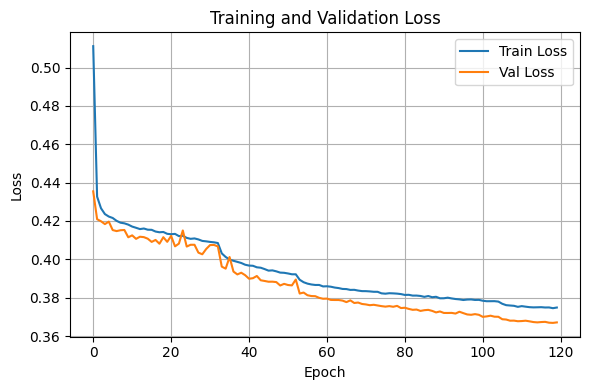

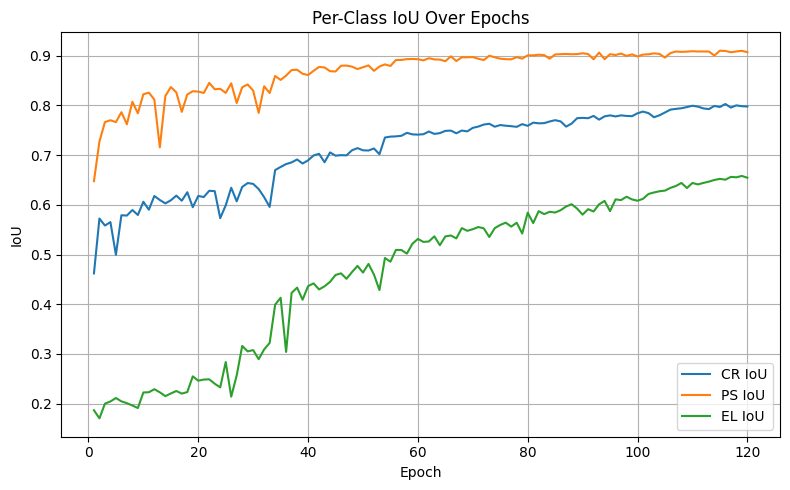

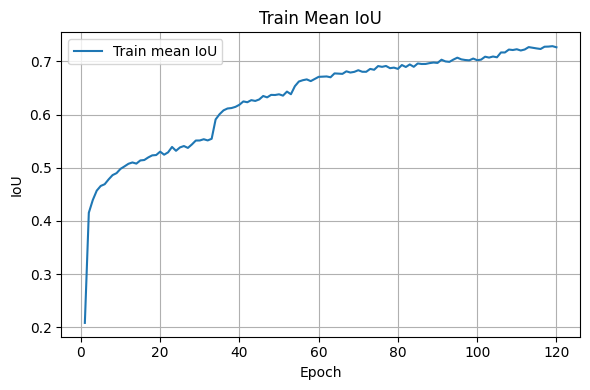

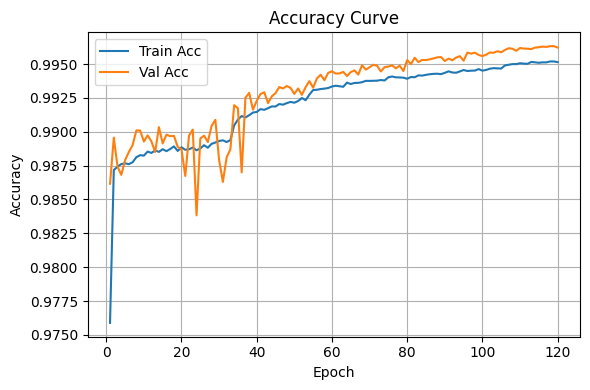

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Loss -----
plt.figure(figsize=(6,4))
plt.plot(train_hist, label='Train Loss')
plt.plot(val_hist,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Helper to stack per-class metrics regardless of tensor/np/list input
def stack_metrics(seq):
    rows = []
    for x in seq:
        if hasattr(x, "detach"):              # torch tensor (vector)
            x = x.detach().cpu().numpy()
        elif hasattr(x, "cpu") and hasattr(x, "numpy"):  # torch.tensor on cpu
            x = x.cpu().numpy()
        rows.append(np.asarray(x, dtype=float))
    return np.vstack(rows)  # (epochs, num_classes)

# ----- Per-class IoU (validation) -----
iou_val_arr = stack_metrics(iou_val_hist)      # shape: (E, C)
epochs = np.arange(1, iou_val_arr.shape[0] + 1)
class_names = ['CR', 'PS', 'EL'][:iou_val_arr.shape[1]]

plt.figure(figsize=(8,5))
for j, name in enumerate(class_names):
    plt.plot(epochs, iou_val_arr[:, j], label=f'{name} IoU')
plt.xlabel('Epoch'); plt.ylabel('IoU'); plt.title('Per-Class IoU Over Epochs')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ----- Mean IoU (train) if you want it -----
if len(iou_tr_hist) == len(epochs):
    plt.figure(figsize=(6,4))
    plt.plot(epochs, iou_tr_hist, label='Train mean IoU')
    plt.xlabel('Epoch'); plt.ylabel('IoU'); plt.title('Train Mean IoU')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ----- Accuracy -----
plt.figure(figsize=(6,4))
plt.plot(epochs, acc_tr_hist, label='Train Acc')
plt.plot(epochs, acc_val_hist, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


## 9. Visualization of Predictions

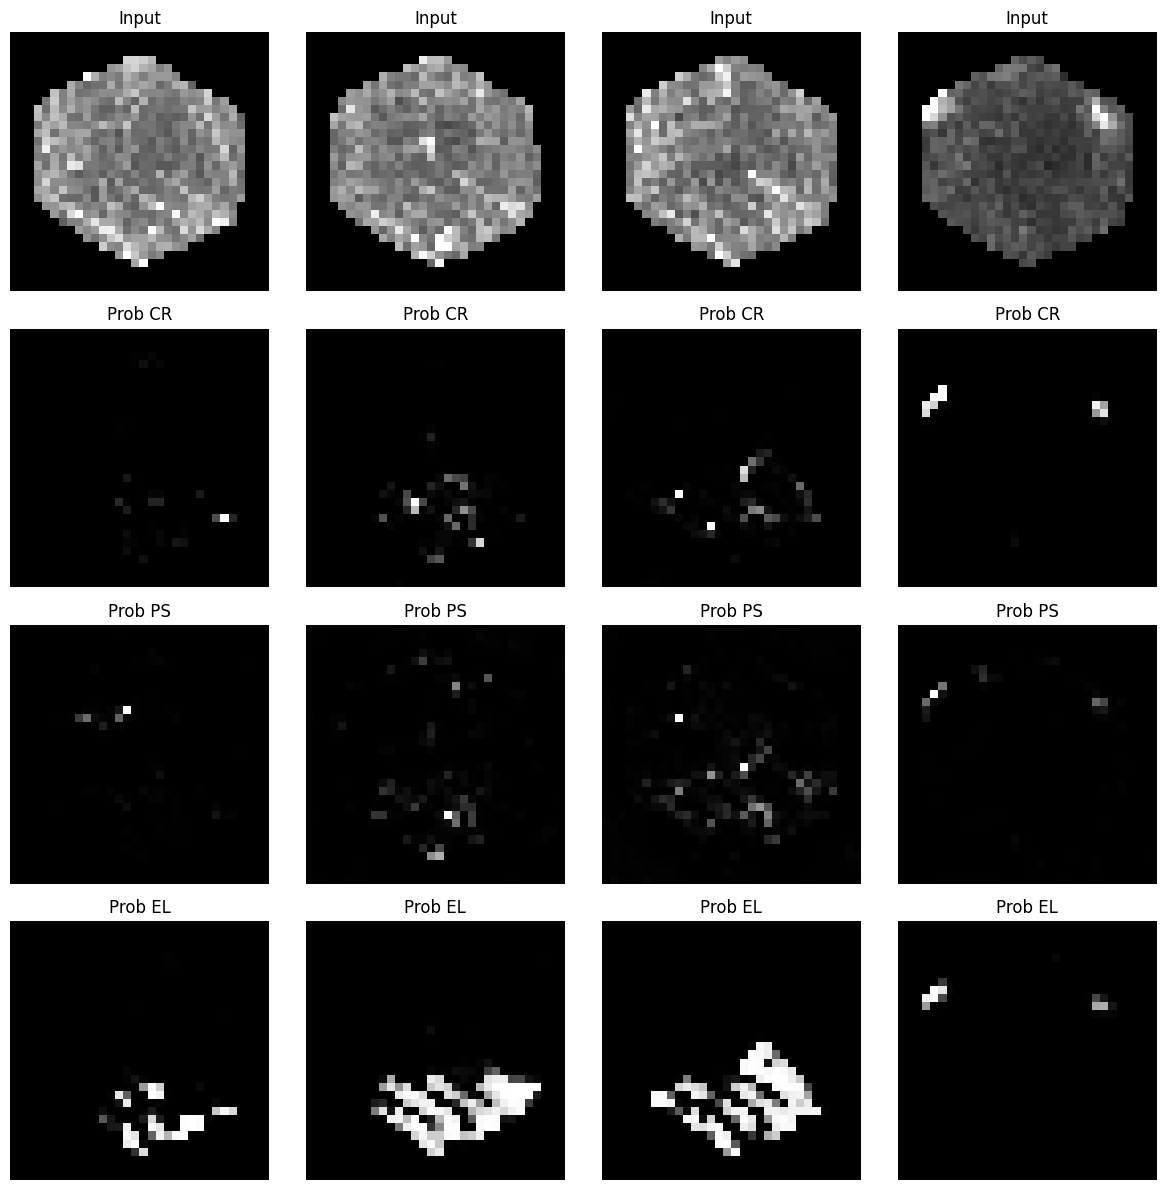

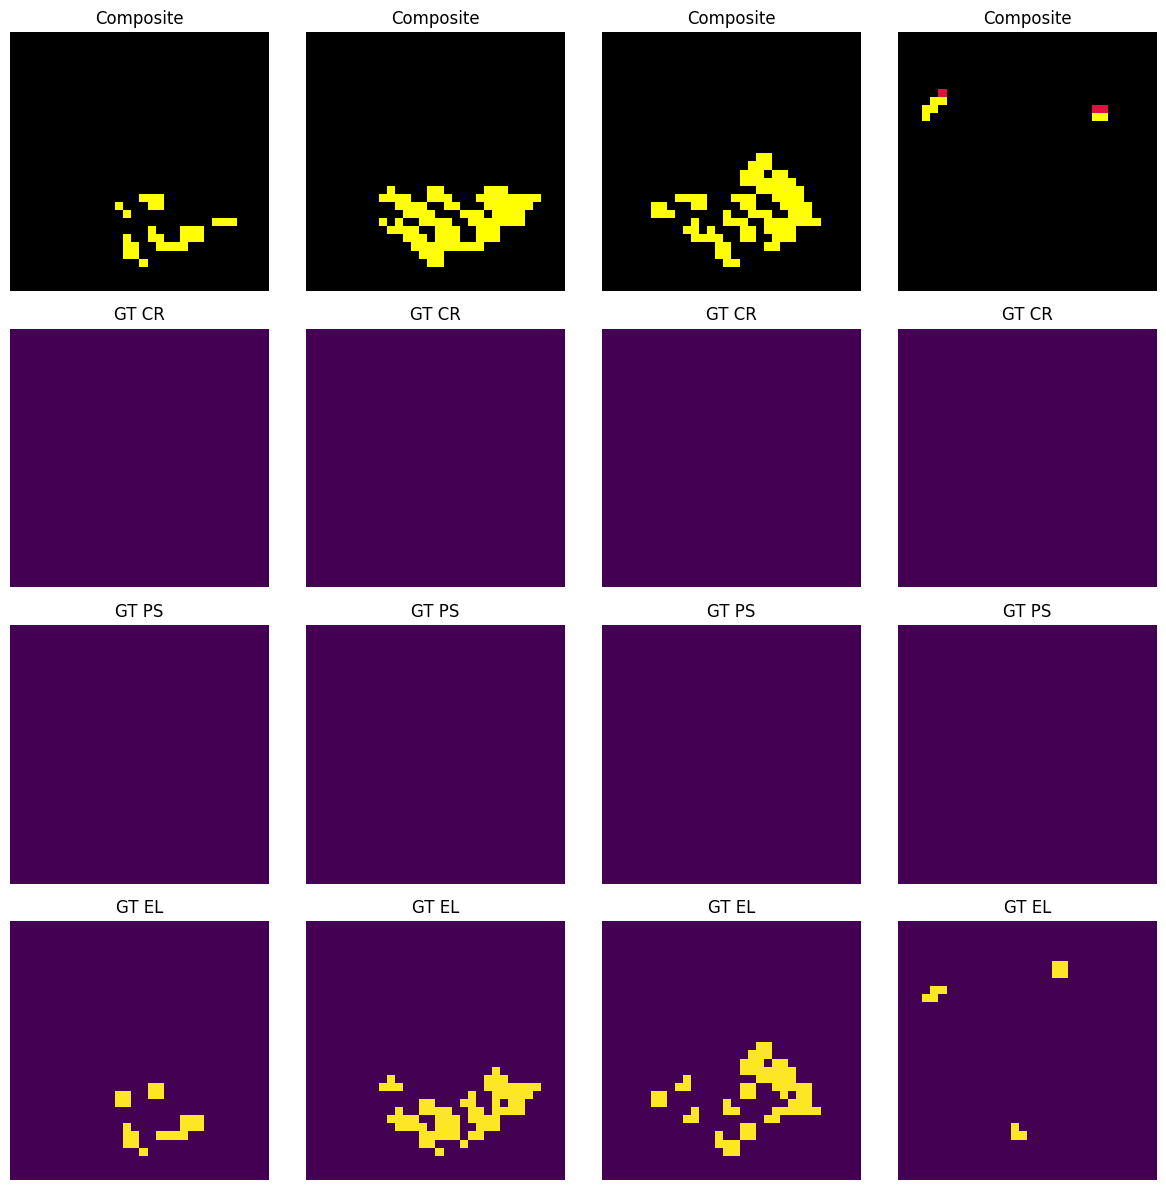

In [13]:
def composite_map(probs, thr=0.5):
    # probs: (3,H,W) tensor
    masks = probs > thr
    colors = torch.tensor([[220,20,60],[255,105,180],[255,255,0]],dtype=torch.uint8)
    H,W = masks.shape[1:]
    comp = torch.zeros(3,H,W,dtype=torch.uint8)
    for i in range(3): comp[:,masks[i]] = colors[i].view(3,1)
    return comp.permute(1,2,0).cpu().numpy()


def shuffle_iter(it):
    entries = list(it)       # collect all batches
    random.shuffle(entries)  # shuffle in place
    return iter(entries)     # return a new iterator

# Grab one shuffled batch from test_loader, then one from val_loader
imgs, msks = next(shuffle_iter(iter(test_loader)))
# imgs, msks = next(shuffle_iter(iter(val_loader)))

# Run inference
# ck = torch.load(Path("/home/theanas12/anasProjects/cmb_Unet_run1/models/checkpoints_multilabel_finetuned/unet_multilabel_ep120_best.pt"), map_location=DEVICE)
# model.load_state_dict(ck['model'])
# model.eval()
with torch.no_grad():
    preds = torch.sigmoid(model(imgs.to(DEVICE)))

# Plot raw probability maps
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    axes[0, i].imshow(imgs[i, 0], cmap='gray')
    axes[0, i].set_title('Input')
    for j, cls in enumerate(['CR', 'PS', 'EL']):
        axes[j+1, i].imshow(preds[i, j].cpu(), cmap='gray')
        axes[j+1, i].set_title(f'Prob {cls}')
for ax in axes.flatten():
    ax.axis('off')
plt.tight_layout()
plt.show()

# Plot composite + ground truth
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    comp = composite_map(preds[i])
    axes[0, i].imshow(comp)
    axes[0, i].set_title('Composite')
    axes[1, i].imshow(msks[i, 0], cmap='viridis')
    axes[1, i].set_title('GT CR')
    axes[2, i].imshow(msks[i, 1], cmap='viridis')
    axes[2, i].set_title('GT PS')
    axes[3, i].imshow(msks[i, 2], cmap='viridis')
    axes[3, i].set_title('GT EL')
for ax in axes.flatten():
    ax.axis('off')
plt.tight_layout()
plt.show()


## 10. Visualization of Predictions Against Ground Truth

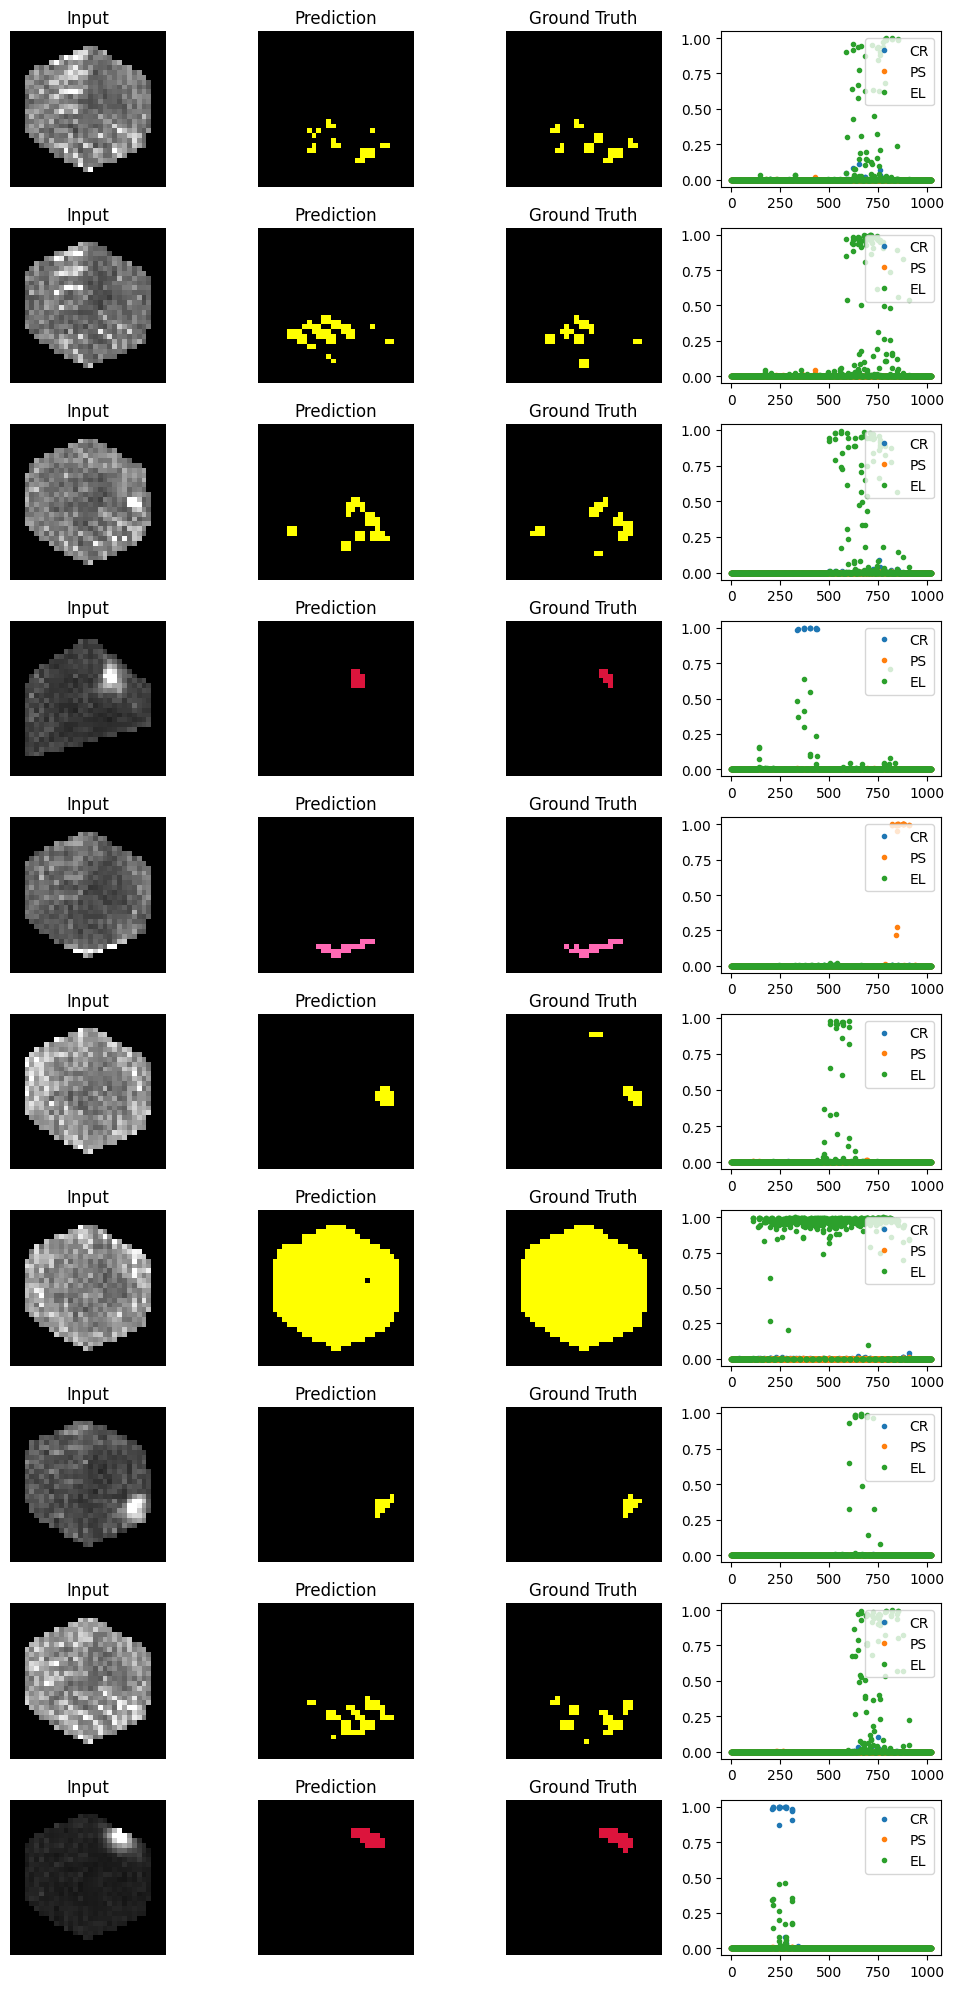

In [14]:
# Cell Y: Random Single-Example Visualization from test_loader
def shuffle_iter(it):
    entries = list(it)       # collect all batches
    random.shuffle(entries)  # shuffle in place
    return iter(entries)     # return a new iterator

N = 10
model.eval()

fig, axes = plt.subplots(N, 4, figsize=(10, 2 * N))
for r in range(N):
    # grab a fresh batch and pick one random sample from it
    # imgs, msks = next(iter(test_loader))
    imgs, msks = next(shuffle_iter(iter(test_loader)))

    idx = random.randrange(imgs.size(0))
    img, msk = imgs[idx], msks[idx]

    with torch.no_grad():
        pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE)))[0]

    # Input
    axes[r, 0].imshow(img[0].cpu(), cmap='gray')
    axes[r, 0].set_title('Input')

    # Prediction composite
    comp = composite_map(pred, thr=0.75)
    axes[r, 1].imshow(comp)
    axes[r, 1].set_title('Prediction')

    # Ground-truth composite
    gt_comp = composite_map(msk)
    axes[r, 2].imshow(gt_comp)
    axes[r, 2].set_title('Ground Truth')

    # Per-channel probabilities
    axes[r, 3].plot(pred[0].cpu().flatten(), '.', label='CR')
    axes[r, 3].plot(pred[1].cpu().flatten(), '.', label='PS')
    axes[r, 3].plot(pred[2].cpu().flatten(), '.', label='EL')
    axes[r, 3].legend(loc='upper right')

    # Turn off axes for first three columns
    for c in range(3):
        axes[r, c].axis('off')

plt.tight_layout()
plt.show()
